In [37]:
import pandas as pd
import numpy as np
import spacy

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

# import morfeusz2

import matplotlib.pyplot as plt
import seaborn as sns

#from sentence_transformers import SentenceTransformer
import umap
import hdbscan

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import utils
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

import re

from wordcloud import WordCloud
import shap

from nltk import ngrams
import nltk

import scipy
from sklearn.model_selection import cross_validate

from utils import *

from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7,progress_bar=True)

from parallelbar import progress_map


from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

from gensim.models import KeyedVectors

import torch
from torch import nn, optim
import torch.nn.functional as F

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [38]:
import multiprocessing.dummy as mp 

In [3]:
# https://github.com/sdadas/polish-nlp-resources
word2vec = KeyedVectors.load("../word2vec/word2vec_100_3_polish.bin")

## Load data

In [4]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

In [5]:
df = df[ df['assestment'] != 'brak' ]
df['assestment'].value_counts()

Prawda               2831
falsz                1308
Fałsz                1136
zbity_zegar           707
Manipulacja           705
raczej_falsz          288
polprawda             254
Nieweryfikowalne      236
prawda                179
blisko_prawdy          93
Częściowy fałsz       9
Name: assestment, dtype: int64

In [6]:
df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df['assestment'].value_counts()

Fałsz               3439
Prawda              3103
Manipulacja          968
Nieweryfikowalne     236
Name: assestment, dtype: int64

In [7]:
df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

In [8]:
df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

In [9]:
y_train = df.copy()['assestment']
X_train = df.copy().loc[:, df.columns != 'assestment']

## Create POS ngrams embeddings

In [10]:
org_cols = [
    'sentiment_all', 'sentiment_avg', 'uniq_words', 'uniq_lemm', 'err', 'net', 
    'words_start_upper', 'words_full_upper', 
    'exclamation_marks', 'question_marks', 'upper_letters', 'chars', 'word2vec']

In [43]:
def create_pos_features(X, y, min_pos=5, min_corr=0.05, org_cols=org_cols):
    words =  sum(X['TEXT_POS'].str.split(' ').values.tolist(), [])
    
    n1 = (pd.Series(nltk.ngrams(words, 1)).value_counts()) 
    n2 = (pd.Series(nltk.ngrams(words, 2)).value_counts()) 
    n3 = (pd.Series(nltk.ngrams(words, 3)).value_counts()) 
    
    n1 = n1[n1>min_pos]
    n2 = n2[n2>min_pos]
    n3 = n3[n3>min_pos]
            
        
    pos = {}

    for n in tqdm(n1.index.tolist() + n2.index.tolist() + n3.index.tolist()):
        x = X['TEXT_POS'].str.count(' '.join(n)) / X['TEXT_POS'].str.split(' ').str.len()

        r = scipy.stats.pearsonr(x.values, y)[0]

        if r > min_corr:
            pos[' '.join(n)] = x
            pos[' '.join(n)].name = ' '.join(n)
         
    
    X_val = pd.concat( [X.loc[:,~X.columns.isin(['ADJ', 'ADV', 'NOUN'])]] + list( pos.values() ), axis=1 )
    
    
    col_use = org_cols + list(pos.keys())
    
    col_use = list(set(col_use)) 
    
    
    return X_val[col_use], list(pos.keys())

In [44]:
def transform_pos_test(X_t, col_pos, org_cols=org_cols):
    pos = {}
    
    for n in col_pos:
        x = X_t['TEXT_POS'].str.count(' '.join(n)) / X_t['TEXT_POS'].str.split(' ').str.len()

        pos[n] = x
        pos[n].name = n
                    
    X_val = pd.concat( 
        [X_t.loc[:,~X_t.columns.isin(['ADJ', 'ADV', 'NOUN'])].copy()] 
        + 
        list( pos.values() ), 
        axis=1 )
        
    col_use = org_cols + col_pos
    
    col_use = list(set(col_use)) 
    
    return X_val[col_use]

## Undersampling data

In [13]:
# logisticRegr = LogisticRegression(max_iter=1000)

# undersampling

y_train_u = y_train.sort_index()
X_train_u = X_train.sort_index()

### Add tokenized words

In [14]:
tasks = X_train_u['text_clean'].values.tolist()
result = progress_map(tokenize, tasks, n_cpu=7, chunk_size=1, core_progress=True)

X_train_u['words'] = result

Core 1:   0%|          | 0/935 [00:00<?, ?it/s]

Core 2:   0%|          | 0/935 [00:00<?, ?it/s]

Core 3:   0%|          | 0/935 [00:00<?, ?it/s]

Core 4:   0%|          | 0/935 [00:00<?, ?it/s]

Core 5:   0%|          | 0/935 [00:00<?, ?it/s]

Core 6:   0%|          | 0/935 [00:00<?, ?it/s]

Core 7:   0%|          | 0/935 [00:00<?, ?it/s]

### Add embeddings (word2vec)

In [15]:
def sum_w2v_vectors(txt_v):
    out_vec = None
    for v in txt_v:
        try:
            if out_vec:
                out_vec += word2vec.get_vector(v).copy()
            else:
                out_vec = word2vec.get_vector(v).copy()
        except:
            pass
    return out_vec
    
tasks = X_train_u['words'].values.tolist()
result = progress_map(sum_w2v_vectors, tasks, n_cpu=7, chunk_size=1, core_progress=True)

X_train_u['word2vec'] = result

Core 1:   0%|          | 0/935 [00:00<?, ?it/s]

Core 2:   0%|          | 0/935 [00:00<?, ?it/s]

Core 3:   0%|          | 0/935 [00:00<?, ?it/s]

Core 4:   0%|          | 0/935 [00:00<?, ?it/s]

Core 5:   0%|          | 0/935 [00:00<?, ?it/s]

Core 6:   0%|          | 0/935 [00:00<?, ?it/s]

Core 7:   0%|          | 0/935 [00:00<?, ?it/s]

## Analysis words frequencies

In [16]:
X_train_u = X_train_u[X_train_u['words'].apply(len)>0]
y_train_u = y_train_u[y_train_u.index.isin(X_train_u.index)]

In [17]:
df_one = X_train_u.copy()

# df_one = df_one[['tokens']].reset_index().explode('tokens')
df_one = df_one[['words']].reset_index().explode('words')
df_one['n'] = 1
df_one['tokens'] = df_one['words'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )

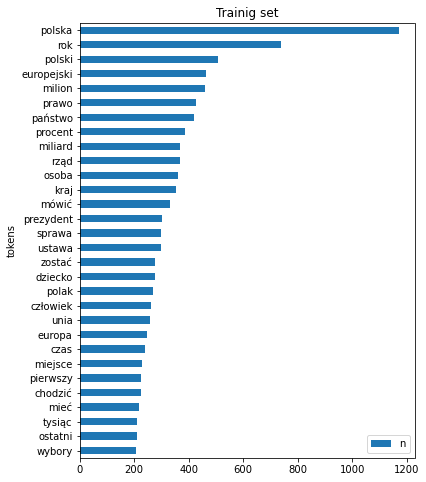

In [18]:
df_one = df_one[df_one['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(6,8));
df_one.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Trainig set')
plt.show()

### Filter out extra stop words

In [19]:
extra_stop_words = set([ 'polska', 'rok', 'polski', 'europejski', 'milion'] 
                       + 
                       df_one.groupby('tokens').agg(n=('n','sum')).query('n<6').index.values.tolist())

In [20]:
def filter_stop_words(words, stop_words = extra_stop_words):
    out = [x for x in words if x not in stop_words]
    return out

tasks = X_train_u['words'].values.tolist()
result = progress_map(filter_stop_words, tasks, n_cpu=7, chunk_size=1, core_progress=True)

X_train_u['words_clean'] = result

Core 1:   0%|          | 0/935 [00:00<?, ?it/s]

Core 2:   0%|          | 0/935 [00:00<?, ?it/s]

Core 3:   0%|          | 0/935 [00:00<?, ?it/s]

Core 4:   0%|          | 0/935 [00:00<?, ?it/s]

Core 5:   0%|          | 0/935 [00:00<?, ?it/s]

Core 6:   0%|          | 0/935 [00:00<?, ?it/s]

Core 7:   0%|          | 0/935 [00:00<?, ?it/s]

### LDA optimization

https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin

In [22]:
dictionary = gensim.corpora.Dictionary(X_train_u['words_clean'].values)
bow_corpus = [dictionary.doc2bow(doc) for doc in X_train_u['words_clean'].values]

# Considering 1-15 topics, as the last is cut off
num_keywords = 15
num_topics = list(range(1,num_keywords+2))

LDA_models = {}
LDA_topics = {}
for i in tqdm(num_topics):
    LDA_models[i] = gensim.models.LdaMulticore(corpus=bow_corpus,
                                             id2word=dictionary,
                                             num_topics=i,
#                                              update_every=1,
#                                              chunksize=len(bow_corpus),
                                             passes=10,
#                                              alpha='auto',
                                             random_state=111,
                                             workers=7)
    
    

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

100%|███████████████████████████████████████████| 16/16 [01:21<00:00,  5.11s/it]


In [23]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [24]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [25]:
coherences = [CoherenceModel(model=LDA_models[i], 
                             texts=X_train_u['words_clean'].values, 
                             dictionary=dictionary, 
                             coherence='c_v').get_coherence()\
              for i in tqdm(num_topics[:-1])]

100%|███████████████████████████████████████████| 15/15 [00:09<00:00,  1.57it/s]


In [26]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] 
# limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] 
# choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

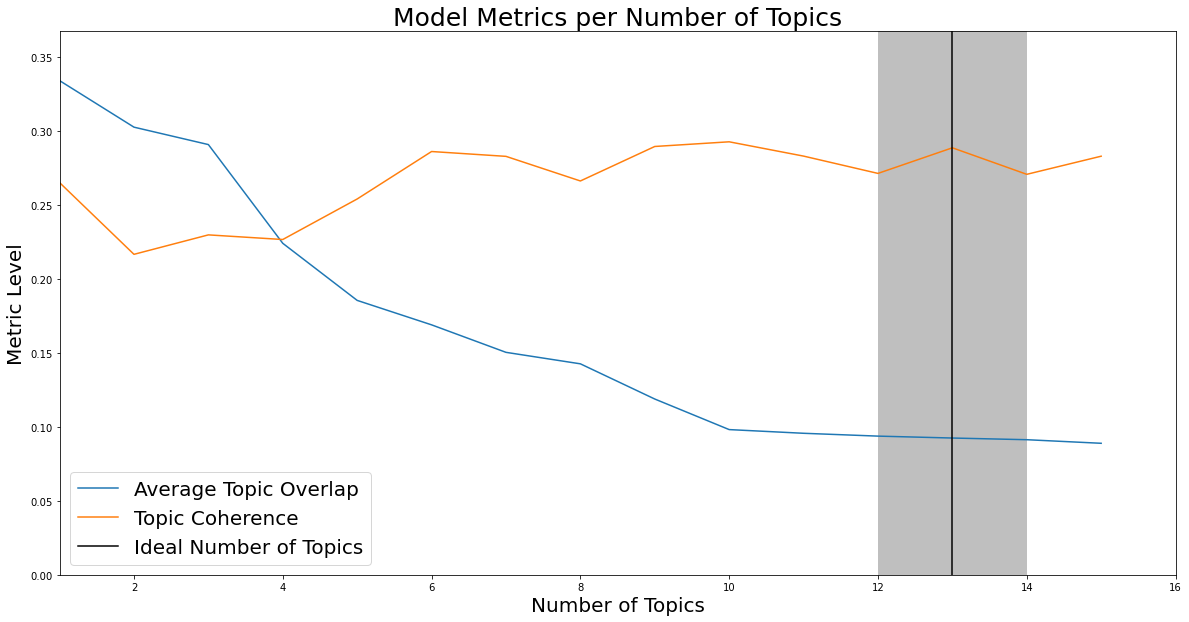

In [27]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

### Hierarchical Dirichlet Process 

In [21]:
#TO DO

## Final number of topics

In [22]:
ideal_topic_num = 10

In [23]:
dictionary = gensim.corpora.Dictionary(X_train_u['words_clean'].values)

bow_corpus = [dictionary.doc2bow(doc) for doc in X_train_u['words_clean'].values]


lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = ideal_topic_num, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   random_state=111,
                                   workers = 7)

topics = []

for line in tqdm(X_train_u['words_clean'].values):
    line_bow = dictionary.doc2bow(line)
    doc_lda = lda_model[line_bow]
    
    topics.append( max(doc_lda, key=lambda x:x[1])[0] )

X_train_u['topic'] = topics

100%|█████████████████████████████████████| 6541/6541 [00:04<00:00, 1453.70it/s]


In [24]:
x=lda_model.show_topics(num_topics=ideal_topic_num, num_words=5)

twords={}
for topic,word in x:
    print(topic, word)

0 0.017*"konstytucja" + 0.016*"trybunał" + 0.015*"prezydent" + 0.015*"konstytucyjny" + 0.009*"ustawa"
1 0.024*"prawo" + 0.022*"państwo" + 0.012*"mówić" + 0.010*"publiczny" + 0.008*"pkb"
2 0.027*"kraj" + 0.026*"europa" + 0.021*"unia" + 0.009*"chodzić" + 0.009*"polak"
3 0.014*"osoba" + 0.011*"człowiek" + 0.009*"praca" + 0.008*"dziecko" + 0.007*"mieć"
4 0.023*"sprawa" + 0.016*"ustawa" + 0.015*"sędzia" + 0.013*"sejm" + 0.013*"prawo"
5 0.019*"podatek" + 0.010*"wybory" + 0.010*"miliard" + 0.010*"pierwszy" + 0.009*"wynosić"
6 0.014*"problem" + 0.013*"ostatni" + 0.008*"liczba" + 0.008*"tysiąc" + 0.007*"mieć"
7 0.015*"zostać" + 0.013*"prawo" + 0.010*"kobieta" + 0.009*"prezydent" + 0.009*"komisja"
8 0.021*"osoba" + 0.018*"dziecko" + 0.014*"program" + 0.012*"państwo" + 0.011*"tysiąc"
9 0.039*"miliard" + 0.016*"budżet" + 0.015*"rząd" + 0.014*"procent" + 0.014*"złoty"


In [25]:
X_train_u['topic'].value_counts()

9    794
2    789
8    735
1    711
4    677
7    618
5    602
3    556
0    539
6    520
Name: topic, dtype: int64

In [26]:
y_train_u_test = pd.DataFrame(y_train_u.copy())
y_train_u_test['topic'] = X_train_u['topic']
y_train_u_test['n'] = 1
y_train_u_test.groupby(['topic', 'assestment']).sum().reset_index().pivot('topic','assestment','n')

assestment,0,1
topic,,
0,286,253
1,406,305
2,427,362
3,352,204
4,389,288
5,284,318
6,241,279
7,382,236
8,322,413


### Prepare CV

In [45]:
class Classifier(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        self.fc1 = nn.Linear(n_input, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 2)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [30]:
cv_fold = []

for i in X_train_u['topic'].unique().reshape(5,-1):
    train_cv = X_train_u.index[ ~np.isin(X_train_u["topic"], i) ].values
    test_cv = X_train_u.index[ np.isin(X_train_u["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

# X_train_v, _ = create_pos_features(X_train_u, y_train_u, 5, 0.05)
X_train_v = X_train_u.copy()

normalize_data = True
vec_final_size = 5
add_word2vec = False

for train_cv, test_cv in cv_fold:
#     logisticRegr = LogisticRegression(max_iter=5000, C=0.1)

    X_train = X_train_v[X_train_v.index.isin(train_cv)]
    y_train = y_train_u[y_train_u.index.isin(train_cv)]
    
    X_train, col_pos = create_pos_features(X_train, y_train, 1, 0.05)    
    
    if add_word2vec:
        umap_word2vec = umap.UMAP(n_neighbors=15, 
                            n_components=vec_final_size, 
                            metric='cosine')
    
        umap_word2vec.fit(np.stack( X_train['word2vec'].values ))
    
        train_embeddings = umap_word2vec.transform(np.stack( X_train['word2vec'].values ))

        X_train[[ 'e'+str(i) for i in range(vec_final_size) ]] = train_embeddings
    
    if normalize_data:
        m = X_train.mean()
        s = X_train.std()
        X_train = (X_train - m)/s
    
    print(X_train.shape)
    

    X_test = X_train_v[X_train_v.index.isin(test_cv)]
    y_test = y_train_u[y_train_u.index.isin(test_cv)]
    
    X_test = transform_pos_test(X_test, col_pos)
    
    if add_word2vec:
        test_embeddings = umap_word2vec.transform(np.stack( X_test['word2vec'].values ))
    
        X_test[[ 'e'+str(i) for i in range(vec_final_size) ]] = test_embeddings


    if normalize_data:
            X_test = (X_test - m)/s
    
    try:
        del X_train['word2vec']
        del X_test['word2vec']
    except:
        pass
    
#     logisticRegr.fit(X_train, y_train)
    
#     y_pred = logisticRegr.predict(X_test)

    model = Classifier(n_input=X_train.shape[1])
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    epochs = 10
    
    train_losses = []
    for e in range(epochs):
        running_loss = 0

        optimizer.zero_grad()

        log_ps = model( torch.from_numpy(X_train.values).float() )
        loss = criterion(log_ps, torch.from_numpy(y_train.values).long() )
        loss.backward()
        optimizer.step()

        running_loss = loss.item()

        model.train()

        train_losses.append(running_loss/len(trainloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/X_train.shape[0]))
    
    with torch.no_grad():
        log_ps = model( torch.from_numpy(X_test.values).float() )
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
    y_pred = top_class.numpy()
    
    confusion = confusion_matrix(y_test, y_pred)
    print(confusion)
        
#     TN, FP = confusion[0, 0], confusion[0, 1]
#     FN, TP = confusion[1, 0], confusion[1, 1]
    
    results['test_accuracy'].append( accuracy_score(y_test, y_pred) ) 
    results['test_precision'].append( precision_score(y_test, y_pred) ) 
    results['test_recall'].append( recall_score(y_test, y_pred) ) 
    results['test_f1'].append( f1_score(y_test, y_pred) ) 
        
metrics = {
    "Accuracy": np.array(results['test_accuracy']).mean(),
    "Precision": np.array(results['test_precision']).mean(),
    "Recall": np.array(results['test_recall']).mean(),
    "F1 Score": np.array(results['test_f1']).mean(),
    }

metrics

 47%|██████████████████▏                    | 1349/2888 [01:23<01:41, 15.12it/s]

## One-hot embeddings

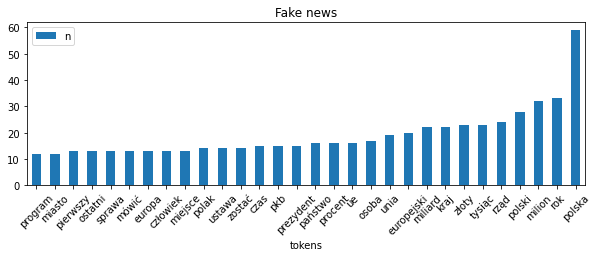

In [176]:
f, ax = plt.subplots(figsize=(10,3));
df_one[
    df_one['index'].isin(y_train_b[y_train_b==0].index.values)
].groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='bar', ax=ax)
plt.xticks(rotation = 45) 
plt.title('Fake news')
plt.show()

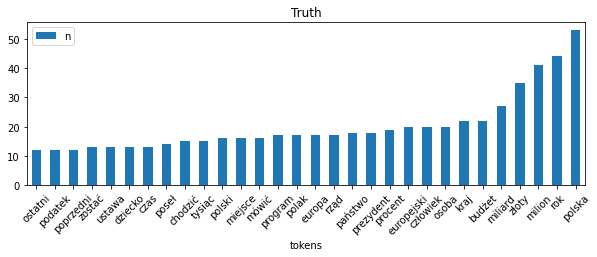

In [179]:
f, ax = plt.subplots(figsize=(10,3));
df_one[
    df_one['index'].isin(y_train_b[y_train_b==1].index.values)
].groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='bar', ax=ax)
plt.xticks(rotation = 45) 
plt.title('Truth')
plt.show()

In [181]:
df_one_trn_p = (
    df_one[['index','tokens','n']]
    .drop_duplicates()
    .pivot(index='index', columns='tokens', values='n')
    .fillna(0)
)
df_one_trn_p.shape

(1296, 4551)

In [182]:
df_one_trn_p = df_one_trn_p.loc[:, ~df_one_trn_p.columns.isin( extra_stop_words )]

In [183]:
df_one_trn_p = df_one_trn_p.loc[:, (df_one_trn_p.sum() > 1)]
df_one_trn_p.shape

(1296, 1875)

In [184]:
df_one_trn_p_20 = df_one_trn_p.loc[:, (df_one_trn_p.sum() > 20)]
df_one_trn_p_20.shape

(1296, 76)

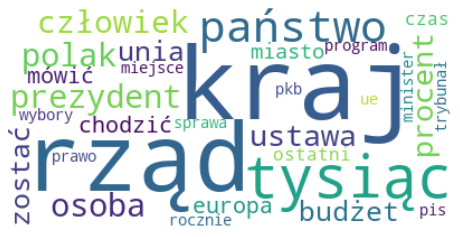

In [185]:
wordcloud = WordCloud(background_color='white',
                      max_words=30).generate_from_frequencies(df_one_trn_p.sum())

f, ax = plt.subplots(figsize=(8,8));
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [186]:
def get_tfidf(df):
    tf = df.divide(df.sum(1).values, axis=0)
    idf = np.log10( (df.shape[0]+1)/(df.sum()+1) )
    tfidf = tf*idf
    gtf = np.log10( df.sum()+1 )
    tfidf_kindof = gtf * idf
    
    return tfidf, tfidf_kindof.sort_values(ascending=False)

In [187]:
tfidf_fn, tfidf_ko_fk =  get_tfidf(df_one_trn_p[y_train.sort_index()==0])
tfidf_t, tfidf_ko_t =  get_tfidf(df_one_trn_p[y_train.sort_index()==1])

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


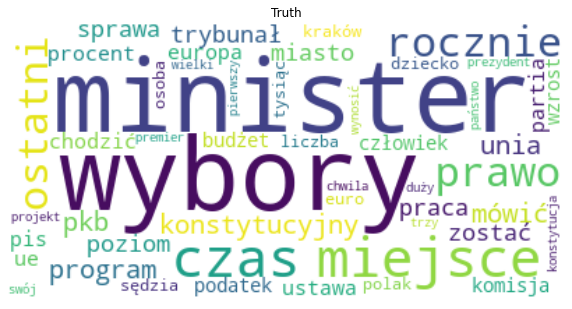

In [188]:
wordcloud = WordCloud(background_color='white',
                      max_words=50).generate_from_frequencies(tfidf_ko_t)

f, ax = plt.subplots(figsize=(10,6));
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Truth')
plt.axis('off')
plt.show()

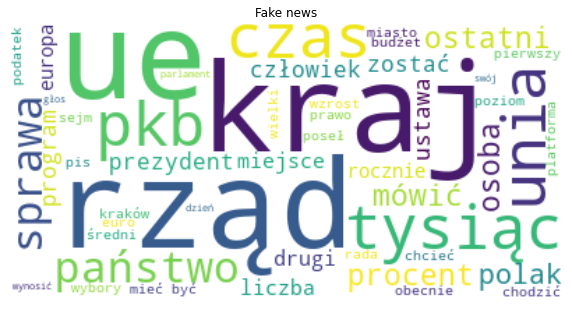

In [189]:
wordcloud = WordCloud(background_color='white',
                      max_words=50).generate_from_frequencies(tfidf_ko_fk)

f, ax = plt.subplots(figsize=(10,6));
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Fake news')
plt.axis('off')
plt.show()

In [190]:
logisticRegr = LogisticRegression()

X_train = df_one_trn_p.sort_index().values

logisticRegr.fit(X_train, y_train_b.sort_index().values)

LogisticRegression()

In [191]:
# train_predictions = logisticRegr.predict(X_train)

scoring = ['accuracy', 'precision', 'recall', 'f1']

results = cross_validate(estimator=logisticRegr,
                       X=X_train,
                       y=y_train_b.values,
                       cv=cv_fold, 
                       scoring=scoring,
                       return_train_score=True)

metrics = {
    "Accuracy": results['test_accuracy'].mean(),
#     "Accuracy Std": results['test_accuracy'].std(),
    "Precision": results['test_precision'].mean(),
#     "Precision Std": results['test_precision'].std(),
    "Recall": results['test_recall'].mean(),
#     "Recall Std": results['test_recall'].std(),
    "F1 Score": results['test_f1'].mean(),
#     "F1 Score Std": results['test_f1'].std()
    }

metrics

{'Accuracy': 0.5330320873388862,
 'Precision': 0.5344978363182595,
 'Recall': 0.5142864575890641,
 'F1 Score': 0.522817458781993}

In [192]:
# train_predictions = logisticRegr.predict(X_train)

scoring = ['accuracy', 'precision', 'recall', 'f1']

results = cross_validate(estimator=logisticRegr,
                       X=X_train,
                       y=y_train_b.values,
                       cv=5,
                       scoring=scoring,
                       return_train_score=True)

metrics = {
    "Accuracy": results['test_accuracy'].mean(),
#     "Accuracy Std": results['test_accuracy'].std(),
    "Precision": results['test_precision'].mean(),
#     "Precision Std": results['test_precision'].std(),
    "Recall": results['test_recall'].mean(),
#     "Recall Std": results['test_recall'].std(),
    "F1 Score": results['test_f1'].mean(),
#     "F1 Score Std": results['test_f1'].std()
    }

metrics

{'Accuracy': 0.5393139293139294,
 'Precision': 0.5396360542679091,
 'Recall': 0.52608228980322,
 'F1 Score': 0.5326743893054664}

In [51]:
# https://quantifyinghealth.com/interpret-logistic-regression-coefficients/
# https://stackoverflow.com/questions/22306341/python-sklearn-how-to-calculate-p-values
from sklearn.feature_selection import chi2
scores, pvalues = chi2(X_train, y_train.sort_index().values)
scores, pvalues_20 = chi2(X_train_20, y_train.sort_index().values)

In [38]:
df_logreg_imp = pd.DataFrame(
    {
        'token' : df_one_trn_p.columns.values.tolist(),
        'coef': importance,
        'coef_abs': np.abs(importance),
        'pvalue' : pvalues
    }
)

In [52]:
df_logreg_imp_20 = pd.DataFrame(
    {
        'token' : df_one_trn_p_20.columns.values.tolist(),
        'coef': importance_20,
        'coef_abs': np.abs(importance_20),
        'pvalue' : pvalues_20
    }
)

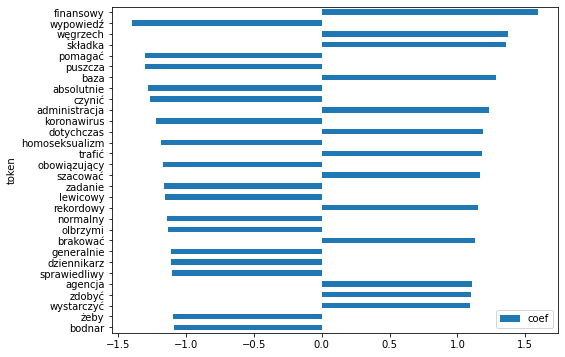

In [39]:
f, ax = plt.subplots(figsize=(8,6));

df_logreg_imp[df_logreg_imp['pvalue']<0.05].sort_values('coef_abs').tail(30)[['token', 'coef']].set_index('token').plot(kind='barh', ax=ax)
plt.show()

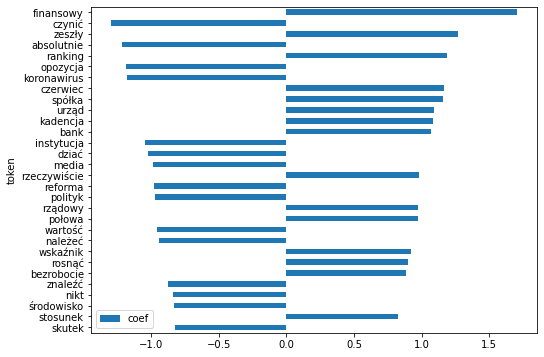

In [55]:
f, ax = plt.subplots(figsize=(8,6));

df_logreg_imp_20[df_logreg_imp_20['pvalue']<0.05].sort_values('coef_abs').tail(30)[['token', 'coef']].set_index('token').plot(kind='barh', ax=ax)
plt.show()

In [40]:
# masker = shap.maskers.Independent(data = X_train)
# explainer = explainer = shap.LinearExplainer(logisticRegr, masker)
# shap_values = explainer.shap_values(X_train)

# shap.summary_plot(shap_values, X_train)

### XGBoost

In [56]:
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='multi:softmax' if False else 'binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

xgbc0.fit(X_train_20 , y_train.sort_index().values)

train_predictions = xgbc0.predict(X_train_20)
test_predictions = xgbc0.predict(X_test_20)

In [57]:
print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2303
           1       0.76      0.68      0.72      2079

    accuracy                           0.74      4382
   macro avg       0.75      0.74      0.74      4382
weighted avg       0.75      0.74      0.74      4382



In [58]:
print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1135
           1       0.63      0.54      0.58      1024

    accuracy                           0.63      2159
   macro avg       0.63      0.63      0.63      2159
weighted avg       0.63      0.63      0.63      2159



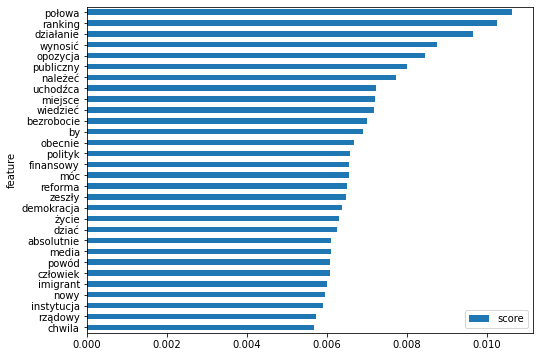

In [59]:
#plotting feature importance
features_list = df_one_trn_p_20.columns.values.tolist()

f, ax = plt.subplots(figsize=(8,6));
df_plot = pd.DataFrame({
    'feature' : features_list,
    'score' : xgbc0.feature_importances_
}).set_index('feature')
df_plot.sort_values('score').tail(30).plot(kind='barh', ax=ax)
plt.show()

### TfIdf approach

In [67]:
logisticRegr = LogisticRegression()

# cols = df_logreg_imp.sort_values('coef_abs').tail(2000)['token'].values
tfidf, _ =  get_tfidf(df_one_trn_p)
tfidf_tst, _ =  get_tfidf(df_one_tst_p)

X_train = tfidf.sort_index().values
X_test = tfidf_tst.sort_index().values

logisticRegr.fit(X_train, y_train.sort_index().values)

train_predictions = logisticRegr.predict(X_train)

print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      2303
           1       0.84      0.76      0.80      2079

    accuracy                           0.82      4382
   macro avg       0.82      0.82      0.82      4382
weighted avg       0.82      0.82      0.82      4382



In [76]:
X_test[np.isnan(X_test)] = 0

In [78]:
test_predictions = logisticRegr.predict(X_test)

print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1135
           1       0.65      0.56      0.60      1024

    accuracy                           0.65      2159
   macro avg       0.65      0.65      0.64      2159
weighted avg       0.65      0.65      0.65      2159



## Investigate ngrams

In [96]:
df_trn_p_fn = df_one_trn[df_one_trn['index'].isin(y_train[y_train==0].index)]
df_trn_p_t = df_one_trn[df_one_trn['index'].isin(y_train[y_train==1].index)]

In [100]:
bigrams_fn = nltk.FreqDist(ngrams(df_trn_p_fn['tokens'].values, 2))
trigrams_fn = nltk.FreqDist(ngrams(df_trn_p_fn['tokens'].values, 3))

bigrams_t = nltk.FreqDist(ngrams(df_trn_p_t['tokens'].values, 2))
trigrams_t = nltk.FreqDist(ngrams(df_trn_p_t['tokens'].values, 3))

In [98]:
bigrams_fn.most_common(20)

[(('unia', 'europejski'), 65),
 (('trybunał', 'konstytucyjny'), 35),
 (('miliard', 'złoty'), 34),
 (('komisja', 'europejski'), 29),
 (('donald', 'tusk'), 27),
 (('być', 'by'), 26),
 (('mieć', 'być'), 26),
 (('prawo', 'sprawiedliwość'), 23),
 (('na', 'przykład'), 23),
 (('milion', 'złoty'), 22),
 (('ostatni', 'rok'), 21),
 (('by', 'być'), 20),
 (('platforma', 'obywatelski'), 18),
 (('jarosław', 'kaczyński'), 16),
 (('wielki', 'brytania'), 16),
 (('być', 'być'), 16),
 (('państwo', 'członkowski'), 15),
 (('wymiar', 'sprawiedliwość'), 15),
 (('chcieć', 'by'), 14),
 (('miejsce', 'praca'), 14)]

In [101]:
bigrams_t.most_common(20)

[(('miliard', 'złoty'), 80),
 (('unia', 'europejski'), 73),
 (('milion', 'złoty'), 45),
 (('trybunał', 'konstytucyjny'), 35),
 (('prawo', 'sprawiedliwość'), 33),
 (('na', 'przykład'), 29),
 (('ostatni', 'rok'), 26),
 (('mieć', 'być'), 24),
 (('przyp', 'red'), 22),
 (('wielki', 'brytania'), 20),
 (('miliard', 'euro'), 19),
 (('jarosław', 'kaczyński'), 17),
 (('procent', 'polak'), 16),
 (('ciąg', 'ostatni'), 16),
 (('stany', 'zjednoczone'), 15),
 (('andrzej', 'duda'), 14),
 (('lech', 'kaczyński'), 14),
 (('bronisław', 'komorowski'), 13),
 (('donald', 'tusk'), 13),
 (('między', 'innymi'), 13)]

In [99]:
trigrams_fn.most_common(20)

[(('chcieć', 'by', 'być'), 10),
 (('krajowy', 'rada', 'sądownictwo'), 8),
 (('kraj', 'unia', 'europejski'), 7),
 (('jan', 'paweł', 'ii'), 6),
 (('rząd', 'platforma', 'obywatelski'), 6),
 (('ciąg', 'ostatni', 'rok'), 6),
 (('rząd', 'prawo', 'sprawiedliwość'), 5),
 (('dziecko', 'zespół', 'down'), 5),
 (('mieć', 'być', 'czynić'), 5),
 (('rząd', 'donald', 'tusk'), 5),
 (('spółka', 'skarb', 'państwo'), 5),
 (('prezydent', 'andrzej', 'duda'), 4),
 (('ii', 'wojna', 'światowy'), 4),
 (('premier', 'beata', 'szydło'), 4),
 (('trybunał', 'sprawiedliwość', 'ue'), 4),
 (('warszawa', 'przyp', 'red'), 4),
 (('przewodniczący', 'rada', 'europejski'), 4),
 (('zgodnie', 'prawo', 'międzynarodowy'), 3),
 (('bliskiego', 'wschód', 'afryka'), 3),
 (('wschód', 'afryka', 'północny'), 3)]

In [102]:
trigrams_t.most_common(20)

[(('ciąg', 'ostatni', 'rok'), 10),
 (('rząd', 'prawo', 'sprawiedliwość'), 10),
 (('kraj', 'unia', 'europejski'), 10),
 (('kwota', 'wolny', 'podatek'), 7),
 (('prezydent', 'bronisław', 'komorowski'), 6),
 (('hanna', 'gronkiewicz', 'waltz'), 6),
 (('plan', 'zagospodarować', 'przestrzenny'), 6),
 (('wysoki', 'izba', 'kontrola'), 5),
 (('chcieć', 'by', 'być'), 5),
 (('spółka', 'skarb', 'państwo'), 5),
 (('narodowy', 'bank', 'polska'), 5),
 (('miliard', 'złoty', 'budżet'), 5),
 (('międzynarodowy', 'fundusz', 'walutowy'), 5),
 (('główny', 'urząd', 'statystyczny'), 5),
 (('prezydent', 'lech', 'kaczyński'), 5),
 (('najwyższ', 'izba', 'kontrola'), 5),
 (('prezydent', 'andrzej', 'duda'), 5),
 (('procent', 'polak', 'uważać'), 4),
 (('milion', 'złoty', 'rocznie'), 4),
 (('program', 'in', 'vitro'), 4)]